# start

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np

import copy
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from collections import defaultdict

folder = "test_results"
os.makedirs(folder, exist_ok=True)

# track neff and sparsity

In [ ]:
def get_linear_mask_per_column(module:nn.Module) -> torch.Tensor:
    x = module.weight.data
    output_size, input_size = x.shape
    x_norm = torch.abs(x) / torch.sum(torch.abs(x), dim=0, keepdim=True)
    neff = torch.floor(1/torch.sum((x_norm ** 2), dim=0, keepdim=True).squeeze(0))
    
    _, indices = torch.sort(x_norm, dim=0, descending=True)
    range_tensor = torch.arange(output_size, device=x.device).unsqueeze(0).expand(input_size, -1).T
    sorted_mask = range_tensor < neff
    
    mask = torch.zeros_like(x, dtype=torch.bool)
    mask.scatter_(0, indices, sorted_mask)
    return mask

def prune_model_neff_per_column(model, renormalize=False):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            mask = get_linear_mask_per_column(module).to(module.weight.device)
            with torch.no_grad():
                pre = module.weight.abs().sum(dim=0, keepdim=True)
                module.weight *= mask
                if renormalize:
                    post = module.weight.abs().sum(dim=0, keepdim=True)
                    module.weight.mul_(pre / post)
    return model

def get_linear_mask_per_row(module:nn.Module) -> torch.Tensor:
    x = module.weight.data
    output_size, input_size = x.shape
    x_norm = torch.abs(x) / torch.sum(torch.abs(x), dim=1, keepdim=True)
    neff = torch.floor(1/torch.sum((x_norm ** 2), dim=1, keepdim=True).squeeze(0))
    
    _, indices = torch.sort(x_norm, dim=1, descending=True)
    range_tensor = torch.arange(input_size, device=x.device).unsqueeze(0).expand(output_size, -1)
    sorted_mask = range_tensor < neff
    
    mask = torch.zeros_like(x, dtype=torch.bool)
    mask.scatter_(1, indices, sorted_mask)
    return mask

def prune_model_neff_per_row(model, renormalize=False):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            mask = get_linear_mask_per_row(module).to(module.weight.device)
            with torch.no_grad():
                pre = module.weight.abs().sum(dim=1, keepdim=True)
                module.weight *= mask
                if renormalize:
                    post = module.weight.abs().sum(dim=1, keepdim=True)
                    module.weight.mul_(pre / post)
    return model


In [3]:
def model_sparsity(model):
    """Calculate the sparsity of the model"""
    total_params = 0
    zero_params = 0
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += torch.sum(param == 0).item()
    
    sparsity = zero_params / total_params
    return sparsity

def per_layer_neff(model):
    """Calculate the effective parameters (Neff) per layer"""
    neff = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            layer_neff = torch.sum(param != 0).item()
            neff[name] = layer_neff
    return neff

In [4]:
# Dataset setup
batch_size = 64
test_batch_size = 1000
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model class with optional dropout
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[512, 512, 512], dropout_rate=0.0):
        super(LinearModel, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        prev_size = input_size
        for size in hidden_size:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
            
        self.output = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        
        for layer in self.layers:
            x = F.relu(layer(x))
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 200 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Testing function
def test(model, device, test_loader):
    """Evaluate model on test set"""
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
    return test_loss, accuracy

# Model configurations
model_configs = {
    'Model_1_Underfit': {
        'hidden_size': [64, 32, 16],  # Very shallow, only 1 small hidden layer
        'lr': 1e-4,  # Lower learning rate
        'epochs': 5,  # Fewer epochs
        'dropout': 0.0,
        'description': 'Underfitted: Too simple (1 layer, 32 units)'
    },
    'Model_2_Slight_Underfit': {
        'hidden_size': [256, 128, 64],  # 2 small layers
        'lr': 5e-4,
        'epochs': 8,
        'dropout': 0.0,
        'description': 'Slightly underfitted: Simple architecture'
    },
    'Model_3_Well_Trained': {
        'hidden_size': [512, 256, 128],  # Moderate depth and width
        'lr': 3e-4,
        'epochs': 15,
        'dropout': 0.2,  # Some regularization
        'description': 'Well-trained: Balanced architecture with dropout'
    },
    'Model_4_Well_Trained_Deep': {
        'hidden_size': [1024, 512, 256],  # Deeper but with dropout
        'lr': 3e-4,
        'epochs': 20,
        'dropout': 0.3,  # More dropout for regularization
        'description': 'Well-trained: Deeper with good regularization'
    },
    'Model_5_Overfit': {
        'hidden_size': [2048, 1024, 1024],  # Very deep and wide
        'lr': 1e-3,  # Higher learning rate
        'epochs': 30,  # Many epochs
        'dropout': 0.0,  # No regularization
        'description': 'Overfitted: Very complex without regularization'
    },
    'Model_6_Extra_Overfit': {
        'hidden_size': [4096, 2048, 1024],  # Extremely deep and wide
        'lr': 1e-3,
        'epochs': 50,
        'dropout': 0.0,
        'description': 'Extra Overfitted: Very complex without regularization'
    },
    'Model_7_Extra_Overfit': {
        'hidden_size': [8192, 4096, 2048],  # Extremely deep and wide
        'lr': 1e-3,
        'epochs': 100,
        'dropout': 0.0,
        'description': 'Extra Overfitted: Very complex without regularization'
    }
}

# Train all models
all_results = {}

for model_name, config in model_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}: {config['description']}")
    print(f"Architecture: Input(784) -> {' -> '.join(map(str, config['hidden_size']))} -> Output(10)")
    print(f"Learning rate: {config['lr']}, Epochs: {config['epochs']}, Dropout: {config['dropout']}")
    print(f"{'='*60}")
    
    # Create model
    model = LinearModel(
        input_size=28*28, 
        output_size=10, 
        hidden_size=config['hidden_size'],
        dropout_rate=config['dropout']
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    
    # Results storage
    result = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
        'config': config,
        'total_params': total_params,
        'pruned_model_per_column_test_loss': [],
        'pruned_model_per_column_test_accuracy': [],
        'per_column_neff': [],
        'per_column_sparsity': [],
        'pruned_model_per_row_test_loss': [],
        'pruned_model_per_row_test_accuracy': [],
        'per_row_neff': [],
        'per_row_sparsity': [],
    }
    
    # Initial test
    test_loss, test_accuracy = test(model, device, test_loader)
    result['test_loss'].append(test_loss)
    result['test_accuracy'].append(test_accuracy)
    
    # Training loop
    for epoch in range(1, config['epochs'] + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        result['train_loss'].append(train_loss)
        result['train_accuracy'].append(train_accuracy)
        
        # Test after each epoch
        test_loss, test_accuracy = test(model, device, test_loader)
        result['test_loss'].append(test_loss)
        result['test_accuracy'].append(test_accuracy)

    result['total_params'] = total_params
    per_column_model = prune_model_neff_per_column(model)
    per_row_model = prune_model_neff_per_row(model)
    
    # Test pruned models
    for name, pruned_model in {
        'per_column': per_column_model,
        'per_row': per_row_model
    }.items():
        test_loss, test_accuracy = test(pruned_model, device, test_loader)
        result[f'pruned_model_{name}_test_loss'].append(test_loss)
        result[f'pruned_model_{name}_test_accuracy'].append(test_accuracy)
        result[f'{name}_neff'].append(per_layer_neff(pruned_model))
        result[f'{name}_sparsity'].append(model_sparsity(pruned_model))

    # Store results
    all_results[model_name] = result
    
    # Save model
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), f'models/{model_name}.pth')
    
    # Final summary
    print(f"\nFinal Results for {model_name}:")
    print(f"Train Accuracy: {result['train_accuracy'][-1]:.2f}%")
    print(f"Test Accuracy: {result['test_accuracy'][-1]:.2f}%")
    print(f"Train-Test Gap: {result['train_accuracy'][-1] - result['test_accuracy'][-1]:.2f}%")
    print(f"per column model test accuracy: {result['pruned_model_per_column_test_accuracy'][-1]:.2f}%")
    print(f"per column model sparsity: {100 * result['per_column_sparsity'][-1]:.2f}%")
    print(f"per column effective parameters: {result['total_params'] * (1 - result['per_column_sparsity'][-1]):.2f}")
    print(f"per row model test accuracy: {result['pruned_model_per_row_test_accuracy'][-1]:.2f}%")
    print(f"per row model sparsity: {100 * result['per_row_sparsity'][-1]:.2f}%")
    print(f"per row effective parameters: {result['total_params'] * (1 - result['per_row_sparsity'][-1]):.2f}")



Using device: cuda

Training Model_1_Underfit: Underfitted: Too simple (1 layer, 32 units)
Architecture: Input(784) -> 64 -> 32 -> 16 -> Output(10)
Learning rate: 0.0001, Epochs: 5, Dropout: 0.0
Total parameters: 53,018
Test set: Average loss: 2.3085, Accuracy: 1092/10000 (10.92%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305164
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.238421
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.853403
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.601426
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.520086
Test set: Average loss: 0.4651, Accuracy: 8702/10000 (87.02%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.485910
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.685831
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.359029
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.320491
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.281890
Test set: Average loss: 0.3267, Accuracy: 9064/10000 (90.64%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.428386
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.350375
Train 

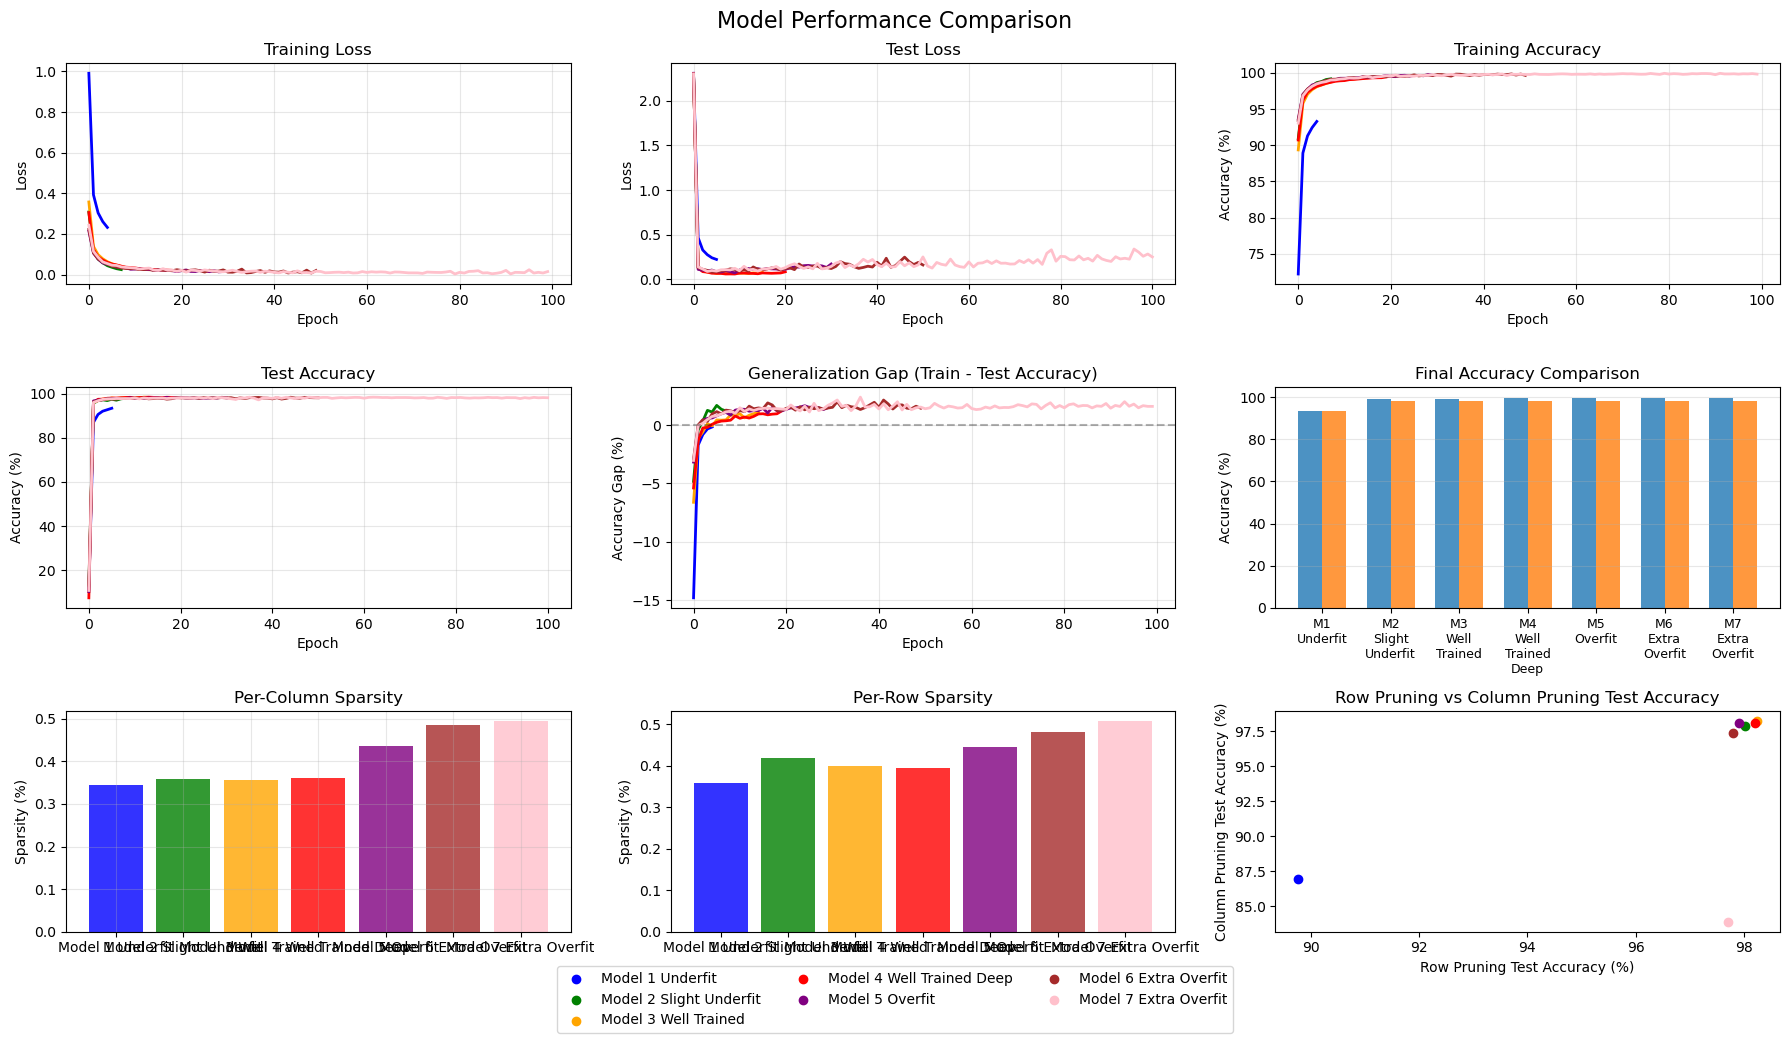

In [7]:
# Plotting results
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink']

# Plot 1: Training Loss
ax = axes[0, 0]
for (model_name, result), color in zip(all_results.items(), colors):
    epochs = range(len(result['train_loss']))
    ax.plot(epochs, result['train_loss'], label=model_name.replace('_', ' '), 
            color=color, linewidth=2)
ax.set_title('Training Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.grid(True, alpha=0.3)

# Plot 2: Test Loss
ax = axes[0, 1]
for (model_name, result), color in zip(all_results.items(), colors):
    epochs = range(len(result['test_loss']))
    ax.plot(epochs, result['test_loss'], label=model_name.replace('_', ' '), 
            color=color, linewidth=2)
ax.set_title('Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.grid(True, alpha=0.3)

# Plot 3: Training Accuracy
ax = axes[0, 2]
for (model_name, result), color in zip(all_results.items(), colors):
    epochs = range(len(result['train_accuracy']))
    ax.plot(epochs, result['train_accuracy'], label=model_name.replace('_', ' '), 
            color=color, linewidth=2)
ax.set_title('Training Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')

ax.grid(True, alpha=0.3)

# Plot 4: Test Accuracy
ax = axes[1, 0]
for (model_name, result), color in zip(all_results.items(), colors):
    epochs = range(len(result['test_accuracy']))
    ax.plot(epochs, result['test_accuracy'], label=model_name.replace('_', ' '), 
            color=color, linewidth=2)
ax.set_title('Test Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')

ax.grid(True, alpha=0.3)

# Plot 5: Train vs Test Accuracy Gap (Overfitting indicator)
ax = axes[1, 1]
for (model_name, result), color in zip(all_results.items(), colors):
    train_acc = result['train_accuracy']
    test_acc = result['test_accuracy'][1:]  # Skip initial test
    gap = [t1 - t2 for t1, t2 in zip(train_acc, test_acc)]
    epochs = range(len(gap))
    ax.plot(epochs, gap, label=model_name.replace('_', ' '), 
            color=color, linewidth=2)
ax.set_title('Generalization Gap (Train - Test Accuracy)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy Gap (%)')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)

ax.grid(True, alpha=0.3)

# Plot 6: Final Performance Summary
ax = axes[1, 2]
model_names = list(all_results.keys())
final_train_acc = [result['train_accuracy'][-1] for result in all_results.values()]
final_test_acc = [result['test_accuracy'][-1] for result in all_results.values()]

x = range(len(model_names))
width = 0.35
ax.bar([i - width/2 for i in x], final_train_acc, width, label='Train', alpha=0.8)
ax.bar([i + width/2 for i in x], final_test_acc, width, label='Test', alpha=0.8)
ax.set_title('Final Accuracy Comparison')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x)
ax.set_xticklabels([name.replace('Model_', 'M').replace('_', '\n') for name in model_names], 
                   rotation=0, fontsize=9)

ax.grid(True, alpha=0.3, axis='y')

# plot 7: sparsity and effective parameters
ax = axes[2, 0]
for (model_name, result), color in zip(all_results.items(), colors):
    ax.bar(model_name.replace('_', ' '), result['per_column_sparsity'], color=color, alpha=0.8)
ax.set_title('Per-Column Sparsity')
ax.set_ylabel('Sparsity (%)')

ax.grid(True, alpha=0.3)

ax = axes[2, 1]
for (model_name, result), color in zip(all_results.items(), colors):
    ax.bar(model_name.replace('_', ' '), result['per_row_sparsity'], color=color, alpha=0.8)
ax.set_title('Per-Row Sparsity')
ax.set_ylabel('Sparsity (%)')


# plot 9: row pruning test accuracy (x-axis) vs column pruning test accuracy (y-axis)
ax = axes[2, 2]
min_x = min(result['pruned_model_per_row_test_accuracy'][-1], result['pruned_model_per_column_test_accuracy'][-1])
x = np.linspace(min_x, 100, 100)


for (model_name, result), color in zip(all_results.items(), colors):
    row_acc = result['pruned_model_per_row_test_accuracy'][-1]
    col_acc = result['pruned_model_per_column_test_accuracy'][-1]
    ax.scatter(row_acc, col_acc, color=color, label=model_name.replace('_', ' '))
ax.set_title('Row Pruning vs Column Pruning Test Accuracy')
ax.set_xlabel('Row Pruning Test Accuracy (%)')
ax.set_ylabel('Column Pruning Test Accuracy (%)')

# legend at the bottom of the entire plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

In [8]:

# Print final summary
print("\n" + "="*80)
print("FINAL SUMMARY OF ALL MODELS")
print("="*80)
for model_name, result in all_results.items():
    config = result['config']
    print(f"\n{model_name}: {config['description']}")
    print(f"  Architecture: {config['hidden_size']}")
    print(f"  Final Train Accuracy: {result['train_accuracy'][-1]:.2f}%")
    print(f"  Final Test Accuracy: {result['test_accuracy'][-1]:.2f}%")
    print(f"  Generalization Gap: {result['train_accuracy'][-1] - result['test_accuracy'][-1]:.2f}%")
    print(f"  Total Parameters: {result['total_params']:,}")
    print(f"  Pruned Model parameters (per column): {result['total_params'] * (1 - result['per_column_sparsity'][-1] ):.2f}")
    print(f"  Pruned Model parameters (per row): {result['total_params'] * (1 - result['per_row_sparsity'][-1]):.2f}")
    print(f"  Pruned Model accuracy (per column): {result['pruned_model_per_column_test_accuracy'][-1]:.2f}%")
    print(f"  Pruned Model accuracy (per row): {result['pruned_model_per_row_test_accuracy'][-1]:.2f}%")
    print(f"  Pruned Model sparsity (per column): {result['per_column_sparsity'][-1]*100:.2f}%")
    print(f"  Pruned Model sparsity (per row): {result['per_row_sparsity'][-1]*100:.2f}%")

    # Characterization
    gap = result['train_accuracy'][-1] - result['test_accuracy'][-1]
    test_acc = result['test_accuracy'][-1]
    
    if test_acc < 95:
        status = "UNDERFITTED"
    elif gap > 5:
        status = "OVERFITTED"
    else:
        status = "WELL-TRAINED"
    
    print(f"  Status: {status}")


FINAL SUMMARY OF ALL MODELS

Model_1_Underfit: Underfitted: Too simple (1 layer, 32 units)
  Architecture: [64, 32, 16]
  Final Train Accuracy: 93.29%
  Final Test Accuracy: 93.46%
  Generalization Gap: -0.17%
  Total Parameters: 53,018
  Pruned Model parameters (per column): 34705.86
  Pruned Model parameters (per row): 34070.40
  Pruned Model accuracy (per column): 86.95%
  Pruned Model accuracy (per row): 89.77%
  Pruned Model sparsity (per column): 34.54%
  Pruned Model sparsity (per row): 35.74%
  Status: UNDERFITTED

Model_2_Slight_Underfit: Slightly underfitted: Simple architecture
  Architecture: [256, 128, 64]
  Final Train Accuracy: 99.18%
  Final Test Accuracy: 97.98%
  Generalization Gap: 1.20%
  Total Parameters: 242,762
  Pruned Model parameters (per column): 155738.82
  Pruned Model parameters (per row): 141358.69
  Pruned Model accuracy (per column): 97.88%
  Pruned Model accuracy (per row): 98.01%
  Pruned Model sparsity (per column): 35.85%
  Pruned Model sparsity (p

# renormalize test

In [9]:
row_pruning_renormalize = prune_model_neff_per_row(model, renormalize=True)
row_pruning = prune_model_neff_per_row(model, renormalize=False)

# Test the pruned models
test_loss, test_accuracy = test(row_pruning_renormalize, device, test_loader)
print(f"Row Pruning Renormalized Test Accuracy: {test_accuracy:.2f}%")

test_loss, test_accuracy = test(row_pruning, device, test_loader)
print(f"Row Pruning Test Accuracy: {test_accuracy:.2f}%")

Test set: Average loss: 2.8890, Accuracy: 9734/10000 (97.34%)

Row Pruning Renormalized Test Accuracy: 97.34%
Test set: Average loss: 0.7357, Accuracy: 9770/10000 (97.70%)

Row Pruning Test Accuracy: 97.70%
